# 2.3 Model Training - Capped Pairs Per Symbol

Test whether capping pairs per symbol reduces overfitting to high-frequency symbols.

**Hypothesis**: Symbols with more news days appear in more pairs, causing the model to overfit to their patterns. By capping the number of pairs per symbol per day, we force more uniform exposure.

**Experiment**: Compare model performance with:
1. No cap (baseline - all pairs)
2. Max 20 pairs per symbol per day
3. Max 10 pairs per symbol per day
4. Max 5 pairs per symbol per day

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from scipy.stats import spearmanr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    # Feature dimensions
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    
    # Encoder latent dimensions
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    
    # Dropout
    fundamental_dropout: float = 0.2
    price_dropout: float = 0.2
    news_dropout: float = 0.3
    
    # News influence cap
    news_alpha: float = 0.8
    
    # Training
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    n_epochs: int = 5
    
    # NEW: Pairs per symbol cap (None = no cap)
    max_pairs_per_symbol: int | None = None

## 1. Load Data

In [11]:
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

print(f"Dataset: {len(df):,} rows")
print(f"Date range: {df['feature_date'].min().date()} to {df['feature_date'].max().date()}")
print(f"Symbols: {df['symbol'].nunique():,}")

Dataset: 2,092,929 rows
Date range: 2021-01-13 to 2025-12-18
Symbols: 3,506


In [12]:
# Feature columns
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in df.columns if c.endswith("_z") and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in df.columns if c.startswith("emb_")]

print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

Price features: 9
Fundamental features: 19
Embedding dims: 768


In [13]:
# Time-based split
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
train_end_idx = int(n_dates * 0.7)
val_end_idx = int(n_dates * 0.8)

train_dates = set(dates[:train_end_idx])
val_dates = set(dates[train_end_idx:val_end_idx])
test_dates = set(dates[val_end_idx:])

train_df = df[df["feature_date"].isin(train_dates)].copy()
val_df = df[df["feature_date"].isin(val_dates)].copy()
test_df = df[df["feature_date"].isin(test_dates)].copy()

print(f"Train: {len(train_df):,} rows, {len(train_dates)} days")
print(f"Val: {len(val_df):,} rows, {len(val_dates)} days")
print(f"Test: {len(test_df):,} rows, {len(test_dates)} days")

Train: 1,418,494 rows, 830 days
Val: 210,247 rows, 118 days
Test: 464,188 rows, 238 days


## 2. Analyze Symbol Frequency Imbalance

In [14]:
# Filter to news-only rows
has_news = (train_df[emb_cols].abs().sum(axis=1) > 0)
train_news = train_df[has_news].copy()

print(f"Training rows with news: {len(train_news):,} ({len(train_news)/len(train_df)*100:.1f}%)")

Training rows with news: 339,872 (24.0%)


In [15]:
# Count news days per symbol
symbol_news_days = train_news.groupby('symbol').size().sort_values(ascending=False)

print("Symbol news frequency distribution:")
print(symbol_news_days.describe())

print(f"\nTop 20 most frequent symbols:")
for sym, count in symbol_news_days.head(20).items():
    print(f"  {sym}: {count} days")

print(f"\nBottom 20 (least frequent):")
for sym, count in symbol_news_days.tail(20).items():
    print(f"  {sym}: {count} days")

Symbol news frequency distribution:
count    2477.000000
mean      137.211143
std       163.832523
min         1.000000
25%        12.000000
50%        85.000000
75%       193.000000
max       830.000000
dtype: float64

Top 20 most frequent symbols:
  TSLA: 830 days
  AAPL: 830 days
  AMZN: 830 days
  META: 829 days
  GOOGL: 828 days
  MSFT: 827 days
  GOOG: 827 days
  NVDA: 820 days
  DIS: 819 days
  F: 805 days
  CVX: 803 days
  AMD: 801 days
  WMT: 800 days
  INTC: 799 days
  PFE: 799 days
  NFLX: 799 days
  GM: 786 days
  PYPL: 781 days
  BA: 778 days
  JPM: 774 days

Bottom 20 (least frequent):
  COSM: 1 days
  REED: 1 days
  NBTX: 1 days
  AMST: 1 days
  NCNA: 1 days
  EEIQ: 1 days
  RCMT: 1 days
  TENX: 1 days
  NIVF: 1 days
  CMTG: 1 days
  TGL: 1 days
  EIG: 1 days
  NOTE: 1 days
  AXTI: 1 days
  NRGV: 1 days
  PTIX: 1 days
  IPX: 1 days
  TMC: 1 days
  BAOS: 1 days
  SNTG: 1 days


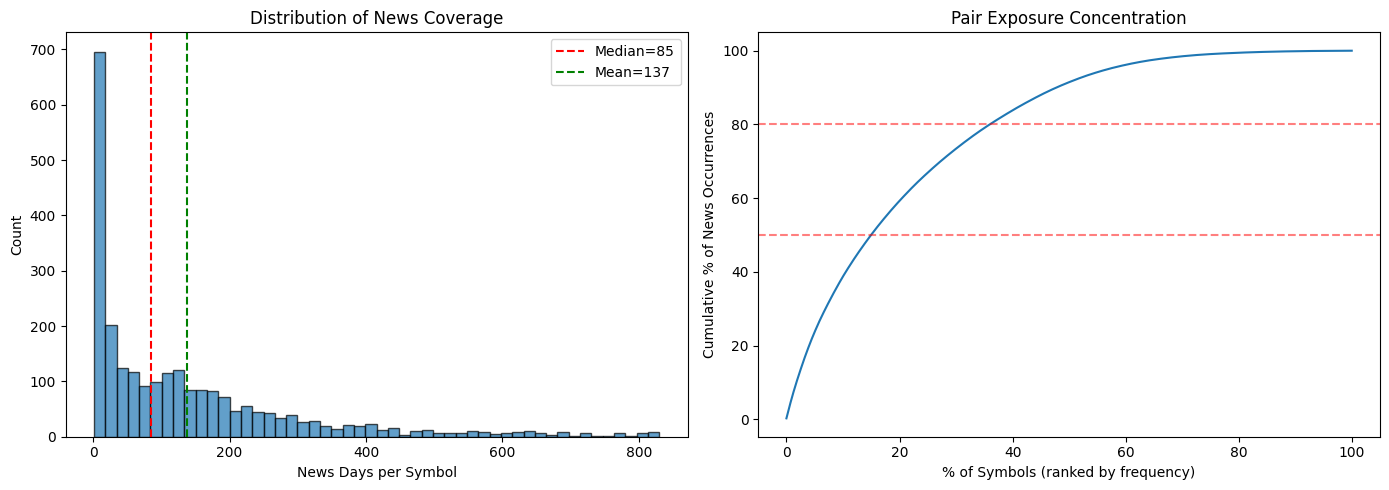


Top 10% of symbols account for 38.6% of news occurrences
Top 20% of symbols account for 59.2% of news occurrences


In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of news days per symbol
ax = axes[0]
ax.hist(symbol_news_days.values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(symbol_news_days.median(), color='red', linestyle='--', label=f'Median={symbol_news_days.median():.0f}')
ax.axvline(symbol_news_days.mean(), color='green', linestyle='--', label=f'Mean={symbol_news_days.mean():.0f}')
ax.set_xlabel('News Days per Symbol')
ax.set_ylabel('Count')
ax.set_title('Distribution of News Coverage')
ax.legend()

# Cumulative: what % of pairs come from top N symbols?
ax = axes[1]
# Estimate pairs contribution (symbol with N days appears in ~N*(avg_symbols_per_day) pairs)
cumulative = symbol_news_days.cumsum() / symbol_news_days.sum()
x = np.arange(len(cumulative)) / len(cumulative) * 100
ax.plot(x, cumulative.values * 100)
ax.axhline(50, color='red', linestyle='--', alpha=0.5)
ax.axhline(80, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('% of Symbols (ranked by frequency)')
ax.set_ylabel('Cumulative % of News Occurrences')
ax.set_title('Pair Exposure Concentration')

plt.tight_layout()
plt.show()

# Calculate concentration
top_10_pct = symbol_news_days.head(int(len(symbol_news_days) * 0.1)).sum() / symbol_news_days.sum()
top_20_pct = symbol_news_days.head(int(len(symbol_news_days) * 0.2)).sum() / symbol_news_days.sum()
print(f"\nTop 10% of symbols account for {top_10_pct*100:.1f}% of news occurrences")
print(f"Top 20% of symbols account for {top_20_pct*100:.1f}% of news occurrences")

## 3. Dataset with Capped Pairs

In [17]:
class CappedPairwiseDataset(Dataset):
    """Pairwise dataset with optional cap on pairs per symbol per day.
    
    This prevents high-frequency symbols from dominating the training signal.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        price_cols: list[str],
        fund_cols: list[str],
        emb_cols: list[str],
        max_pairs_per_symbol: int | None = None,
    ):
        # Filter to rows with news only
        has_news = (df[emb_cols].abs().sum(axis=1) > 0)
        df_news = df[has_news].copy()
        print(f"Filtered to news-only: {len(df_news):,} / {len(df):,} rows ({len(df_news)/len(df)*100:.1f}%)")

        self.df = df_news.reset_index(drop=True)
        self.price_cols = price_cols
        self.fund_cols = fund_cols
        self.emb_cols = emb_cols
        self.max_pairs_per_symbol = max_pairs_per_symbol

        # Group by date
        self.date_groups = {}
        self.date_symbols = {}  # Track symbols per date
        for date, group in df_news.groupby("feature_date"):
            indices = group.index.tolist()
            symbols = group["symbol"].tolist()
            if len(indices) < 2:
                continue
            self.date_groups[date] = np.array(indices)
            self.date_symbols[date] = symbols

        self.dates = list(self.date_groups.keys())
        print(f"Days with sufficient news coverage: {len(self.dates)}")

        # Precompute arrays
        self.price_arr = df_news[price_cols].values.astype(np.float32)
        self.fund_arr = df_news[fund_cols].values.astype(np.float32)
        self.emb_arr = df_news[emb_cols].values.astype(np.float32)
        self.target_arr = df_news["target_return"].values.astype(np.float32)
        self.symbol_arr = df_news["symbol"].values

        # Map original index to position in filtered df
        self.idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(df_news.index)}

        # Generate pairs
        self.pairs = []
        self._generate_pairs()

    def _generate_pairs(self):
        """Generate pairs with optional per-symbol cap."""
        pairs = []
        
        for date in self.dates:
            indices = self.date_groups[date]
            n = len(indices)
            
            if self.max_pairs_per_symbol is None:
                # No cap - generate all pairs
                for i in range(n):
                    for j in range(i + 1, n):
                        idx_i = self.idx_map[indices[i]]
                        idx_j = self.idx_map[indices[j]]
                        pairs.append((idx_i, idx_j))
            else:
                # With cap - track pairs per symbol
                symbol_pair_count = defaultdict(int)
                
                # Shuffle pair order for fairness
                all_pairs = []
                for i in range(n):
                    for j in range(i + 1, n):
                        all_pairs.append((i, j))
                np.random.shuffle(all_pairs)
                
                for i, j in all_pairs:
                    idx_i = self.idx_map[indices[i]]
                    idx_j = self.idx_map[indices[j]]
                    sym_i = self.symbol_arr[idx_i]
                    sym_j = self.symbol_arr[idx_j]
                    
                    # Check if either symbol has hit its cap
                    if (symbol_pair_count[sym_i] >= self.max_pairs_per_symbol or
                        symbol_pair_count[sym_j] >= self.max_pairs_per_symbol):
                        continue
                    
                    pairs.append((idx_i, idx_j))
                    symbol_pair_count[sym_i] += 1
                    symbol_pair_count[sym_j] += 1

        self.pairs = pairs
        cap_str = f"cap={self.max_pairs_per_symbol}" if self.max_pairs_per_symbol else "no cap"
        print(f"Generated {len(self.pairs):,} pairs ({cap_str})")

    def resample_pairs(self):
        """Reshuffle pairs (and regenerate if capped)."""
        if self.max_pairs_per_symbol is not None:
            # Regenerate with new random order
            self._generate_pairs()
        else:
            np.random.shuffle(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]

        price_i = self.price_arr[i]
        price_j = self.price_arr[j]
        fund_i = self.fund_arr[i]
        fund_j = self.fund_arr[j]
        emb_i = self.emb_arr[i]
        emb_j = self.emb_arr[j]

        actual_label = 1.0 if self.target_arr[i] > self.target_arr[j] else 0.0

        # Random swap for label balance
        if np.random.random() < 0.5:
            price_i, price_j = price_j, price_i
            fund_i, fund_j = fund_j, fund_i
            emb_i, emb_j = emb_j, emb_i
            label = 1.0 - actual_label
        else:
            label = actual_label

        return {
            "price_i": torch.tensor(price_i),
            "price_j": torch.tensor(price_j),
            "fund_i": torch.tensor(fund_i),
            "fund_j": torch.tensor(fund_j),
            "emb_i": torch.tensor(emb_i),
            "emb_j": torch.tensor(emb_j),
            "label": torch.tensor(label),
        }

In [18]:
# # Compare pair counts with different caps
# print("Pair counts with different caps:")
# print("=" * 50)

# for cap in [50, 20, 10, 5]:
#     ds = CappedPairwiseDataset(
#         train_df, price_feat_cols, fund_feat_cols, emb_cols,
#         max_pairs_per_symbol=cap
#     )
#     print()

## 4. Model Architecture

In [19]:
class MultiBranchRanker(nn.Module):
    """Multi-branch model with influence-controlled news embedding."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, 64),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(64, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, 32),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(32, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(128, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)
    
    def forward_pair(self, price_i, fund_i, emb_i, price_j, fund_j, emb_j):
        score_i = self.forward(price_i, fund_i, emb_i)
        score_j = self.forward(price_j, fund_j, emb_j)
        return torch.sigmoid(score_i - score_j)

## 5. Training Functions

In [20]:
def pairwise_ranking_loss(pred_prob, label, smoothing=0.1):
    smoothed_label = label * (1 - smoothing) + 0.5 * smoothing
    return F.binary_cross_entropy(pred_prob, smoothed_label)


def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(loader, desc="Training", leave=False):
        price_i = batch["price_i"].to(device)
        price_j = batch["price_j"].to(device)
        fund_i = batch["fund_i"].to(device)
        fund_j = batch["fund_j"].to(device)
        emb_i = batch["emb_i"].to(device)
        emb_j = batch["emb_j"].to(device)
        label = batch["label"].to(device)
        
        optimizer.zero_grad()
        pred_prob = model.forward_pair(price_i, fund_i, emb_i, price_j, fund_j, emb_j)
        loss = pairwise_ranking_loss(pred_prob, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(label)
        total_correct += ((pred_prob > 0.5) == (label > 0.5)).sum().item()
        total_samples += len(label)
    
    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        price_i = batch["price_i"].to(device)
        price_j = batch["price_j"].to(device)
        fund_i = batch["fund_i"].to(device)
        fund_j = batch["fund_j"].to(device)
        emb_i = batch["emb_i"].to(device)
        emb_j = batch["emb_j"].to(device)
        label = batch["label"].to(device)
        
        pred_prob = model.forward_pair(price_i, fund_i, emb_i, price_j, fund_j, emb_j)
        loss = pairwise_ranking_loss(pred_prob, label)
        
        total_loss += loss.item() * len(label)
        total_correct += ((pred_prob > 0.5) == (label > 0.5)).sum().item()
        total_samples += len(label)
    
    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def get_scores(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    """Score all rows in dataframe."""
    model.eval()
    
    price_arr = torch.tensor(df[price_cols].values.astype(np.float32))
    fund_arr = torch.tensor(df[fund_cols].values.astype(np.float32))
    emb_arr = torch.tensor(df[emb_cols].values.astype(np.float32))
    
    scores = []
    for i in range(0, len(df), batch_size):
        price = price_arr[i:i+batch_size].to(device)
        fund = fund_arr[i:i+batch_size].to(device)
        emb = emb_arr[i:i+batch_size].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    return np.concatenate(scores)


def compute_daily_ic(df):
    """Compute Spearman IC per day."""
    ics = []
    for date, group in df.groupby("feature_date"):
        if len(group) < 10:
            continue
        ic, _ = spearmanr(group["score"], group["target_return"])
        if not np.isnan(ic):
            ics.append({"date": date, "ic": ic})
    return pd.DataFrame(ics)


def compute_short_returns(df, k=5, clip_return=0.10):
    """Compute daily short returns for bottom-K with return clipping.
    
    Args:
        df: DataFrame with 'score' and 'target_return' columns
        k: Number of stocks to short
        clip_return: Clip individual stock returns to [-clip, +clip].
                     Default 10% is realistic for daily stock moves.
                     Most stocks don't move more than 10% in a single day.
    """
    returns = []
    for date, group in df.groupby("feature_date"):
        if len(group) < k * 2:
            continue
        bottom = group.nsmallest(k, "score")
        # Clip extreme returns - 10% is realistic for daily moves
        clipped_returns = bottom["target_return"].clip(-clip_return, clip_return)
        short_ret = -clipped_returns.mean()
        returns.append({"date": date, "return": short_ret})
    return pd.DataFrame(returns)

## 6. Train and Compare Models

In [13]:
def train_model(train_df, val_df, config, max_pairs_per_symbol=None, n_epochs=10):
    """Train a model with given pair cap and return results."""
    
    cap_str = f"cap={max_pairs_per_symbol}" if max_pairs_per_symbol else "no_cap"
    print(f"\n{'='*60}")
    print(f"Training model with {cap_str}")
    print(f"{'='*60}")
    
    # Create datasets
    train_dataset = CappedPairwiseDataset(
        train_df, price_feat_cols, fund_feat_cols, emb_cols,
        max_pairs_per_symbol=max_pairs_per_symbol
    )
    val_dataset = CappedPairwiseDataset(
        val_df, price_feat_cols, fund_feat_cols, emb_cols,
        max_pairs_per_symbol=max_pairs_per_symbol
    )
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    # Create model
    model = MultiBranchRanker(config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    
    # Train
    best_val_acc = 0
    history = []
    
    for epoch in range(n_epochs):
        train_dataset.resample_pairs()
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc = eval_epoch(model, val_loader, device)
        scheduler.step()
        
        history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        })
        
        print(f"Epoch {epoch+1}/{n_epochs}: "
              f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_state)
    
    return model, history

In [14]:
# Create config
config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
    n_epochs=5,
)

In [15]:
# Train models with different caps (including baseline no_cap)
caps_to_test = [10,5,3, 2]  # Include baseline (None = no cap)
results = {}

for cap in caps_to_test:
    model, history = train_model(train_df, val_df, config, max_pairs_per_symbol=cap, n_epochs=10)
    
    # Evaluate on test set
    test_df_eval = test_df.copy()
    test_df_eval["score"] = get_scores(model, test_df_eval, price_feat_cols, fund_feat_cols, emb_cols, device)
    
    # Compute metrics
    ic_df = compute_daily_ic(test_df_eval)
    short_df = compute_short_returns(test_df_eval, k=5, clip_return=0.10)  # 10% clip is realistic
    
    mean_ic = ic_df['ic'].mean()
    ic_sharpe = mean_ic / ic_df['ic'].std() * np.sqrt(252)
    
    short_sharpe = short_df['return'].mean() / short_df['return'].std() * np.sqrt(252)
    short_cumret = (1 + short_df['return']).cumprod().iloc[-1] - 1
    
    cap_str = f"cap={cap}" if cap else "no_cap"
    results[cap_str] = {
        'model': model,
        'history': history,
        'mean_ic': mean_ic,
        'ic_sharpe': ic_sharpe,
        'short_sharpe': short_sharpe,
        'short_cumret': short_cumret,
    }
    
    print(f"\n{cap_str} Test Results:")
    print(f"  IC: {mean_ic:.4f} (Sharpe: {ic_sharpe:.2f})")
    print(f"  Short K=5: {short_cumret*100:.1f}% (Sharpe: {short_sharpe:.2f})")


Training model with cap=10
Filtered to news-only: 208,569 / 1,418,494 rows (14.7%)
Days with sufficient news coverage: 830
Generated 1,042,113 pairs (cap=10)
Filtered to news-only: 35,696 / 210,247 rows (17.0%)
Days with sufficient news coverage: 118
Generated 178,379 pairs (cap=10)
Generated 1,042,099 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 1/10: train_acc=0.5157, val_acc=0.5133
Generated 1,042,157 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 2/10: train_acc=0.5212, val_acc=0.5089
Generated 1,042,136 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 3/10: train_acc=0.5251, val_acc=0.5083
Generated 1,042,096 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 4/10: train_acc=0.5308, val_acc=0.5070
Generated 1,042,136 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 5/10: train_acc=0.5386, val_acc=0.5049
Generated 1,042,120 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 6/10: train_acc=0.5453, val_acc=0.5029
Generated 1,042,159 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 7/10: train_acc=0.5515, val_acc=0.5007
Generated 1,042,165 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 8/10: train_acc=0.5563, val_acc=0.5024
Generated 1,042,111 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 9/10: train_acc=0.5588, val_acc=0.5027
Generated 1,042,134 pairs (cap=10)


Training:   0%|          | 0/2036 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 10/10: train_acc=0.5600, val_acc=0.5010

cap=10 Test Results:
  IC: -0.0042 (Sharpe: -0.89)
  Short K=5: 490.4% (Sharpe: 3.91)

Training model with cap=5
Filtered to news-only: 208,569 / 1,418,494 rows (14.7%)
Days with sufficient news coverage: 830
Generated 520,983 pairs (cap=5)
Filtered to news-only: 35,696 / 210,247 rows (17.0%)
Days with sufficient news coverage: 118
Generated 89,187 pairs (cap=5)
Generated 520,993 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/10: train_acc=0.5138, val_acc=0.5109
Generated 520,964 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/10: train_acc=0.5171, val_acc=0.5133
Generated 520,980 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/10: train_acc=0.5187, val_acc=0.5109
Generated 521,004 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/10: train_acc=0.5218, val_acc=0.5118
Generated 520,960 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/10: train_acc=0.5247, val_acc=0.5103
Generated 520,991 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/10: train_acc=0.5270, val_acc=0.5076
Generated 520,956 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/10: train_acc=0.5305, val_acc=0.5065
Generated 521,008 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/10: train_acc=0.5330, val_acc=0.5034
Generated 520,958 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/10: train_acc=0.5342, val_acc=0.5067
Generated 520,969 pairs (cap=5)


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/10: train_acc=0.5360, val_acc=0.5060

cap=5 Test Results:
  IC: 0.0129 (Sharpe: 2.83)
  Short K=5: 2647.9% (Sharpe: 7.19)

Training model with cap=3
Filtered to news-only: 208,569 / 1,418,494 rows (14.7%)
Days with sufficient news coverage: 830
Generated 312,549 pairs (cap=3)
Filtered to news-only: 35,696 / 210,247 rows (17.0%)
Days with sufficient news coverage: 118
Generated 53,493 pairs (cap=3)
Generated 312,525 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/10: train_acc=0.5128, val_acc=0.5142
Generated 312,517 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/10: train_acc=0.5161, val_acc=0.5122
Generated 312,539 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/10: train_acc=0.5178, val_acc=0.5122
Generated 312,553 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/10: train_acc=0.5194, val_acc=0.5112
Generated 312,538 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/10: train_acc=0.5218, val_acc=0.5099
Generated 312,540 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/10: train_acc=0.5232, val_acc=0.5115
Generated 312,532 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/10: train_acc=0.5246, val_acc=0.5086
Generated 312,531 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/10: train_acc=0.5260, val_acc=0.5072
Generated 312,540 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/10: train_acc=0.5256, val_acc=0.5079
Generated 312,527 pairs (cap=3)


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/10: train_acc=0.5266, val_acc=0.5072

cap=3 Test Results:
  IC: 0.0263 (Sharpe: 3.80)
  Short K=5: 11362.3% (Sharpe: 9.79)

Training model with cap=2
Filtered to news-only: 208,569 / 1,418,494 rows (14.7%)
Days with sufficient news coverage: 830
Generated 208,451 pairs (cap=2)
Filtered to news-only: 35,696 / 210,247 rows (17.0%)
Days with sufficient news coverage: 118
Generated 35,678 pairs (cap=2)
Generated 208,464 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10: train_acc=0.5110, val_acc=0.5130
Generated 208,450 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/10: train_acc=0.5150, val_acc=0.5122
Generated 208,447 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/10: train_acc=0.5179, val_acc=0.5146
Generated 208,465 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/10: train_acc=0.5181, val_acc=0.5150
Generated 208,464 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/10: train_acc=0.5198, val_acc=0.5134
Generated 208,473 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6/10: train_acc=0.5208, val_acc=0.5100
Generated 208,454 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 7/10: train_acc=0.5189, val_acc=0.5125
Generated 208,462 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 8/10: train_acc=0.5213, val_acc=0.5127
Generated 208,478 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 9/10: train_acc=0.5218, val_acc=0.5124
Generated 208,444 pairs (cap=2)


Training:   0%|          | 0/408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10/10: train_acc=0.5209, val_acc=0.5124

cap=2 Test Results:
  IC: 0.0282 (Sharpe: 3.86)
  Short K=5: 14704.9% (Sharpe: 9.73)


## 7. Compare Results

In [16]:
# Summary table
summary = []
for cap_str, res in results.items():
    summary.append({
        'config': cap_str,
        'mean_ic': res['mean_ic'],
        'ic_sharpe': res['ic_sharpe'],
        'short_sharpe': res['short_sharpe'],
        'short_return': res['short_cumret'] * 100,
    })

summary_df = pd.DataFrame(summary)
print("\n" + "=" * 70)
print("COMPARISON SUMMARY (Test Set)")
print("=" * 70)
print(summary_df.to_string(index=False))


COMPARISON SUMMARY (Test Set)
config   mean_ic  ic_sharpe  short_sharpe  short_return
cap=10 -0.004157  -0.893136      3.910172    490.415521
 cap=5  0.012929   2.832890      7.192615   2647.913365
 cap=3  0.026323   3.796694      9.789853  11362.266853
 cap=2  0.028199   3.862052      9.734609  14704.910056


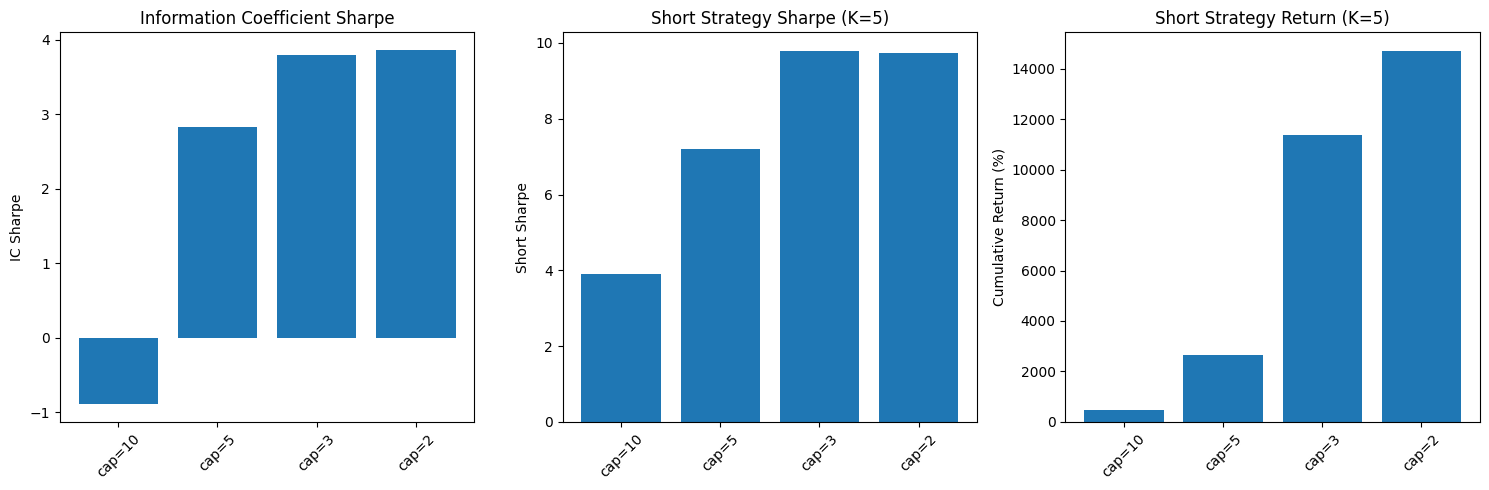

In [17]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

configs = list(results.keys())

# IC Sharpe
ax = axes[0]
ax.bar(configs, [results[c]['ic_sharpe'] for c in configs])
ax.set_ylabel('IC Sharpe')
ax.set_title('Information Coefficient Sharpe')
ax.tick_params(axis='x', rotation=45)

# Short Sharpe
ax = axes[1]
ax.bar(configs, [results[c]['short_sharpe'] for c in configs])
ax.set_ylabel('Short Sharpe')
ax.set_title('Short Strategy Sharpe (K=5)')
ax.tick_params(axis='x', rotation=45)

# Short Return
ax = axes[2]
ax.bar(configs, [results[c]['short_cumret'] * 100 for c in configs])
ax.set_ylabel('Cumulative Return (%)')
ax.set_title('Short Strategy Return (K=5)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

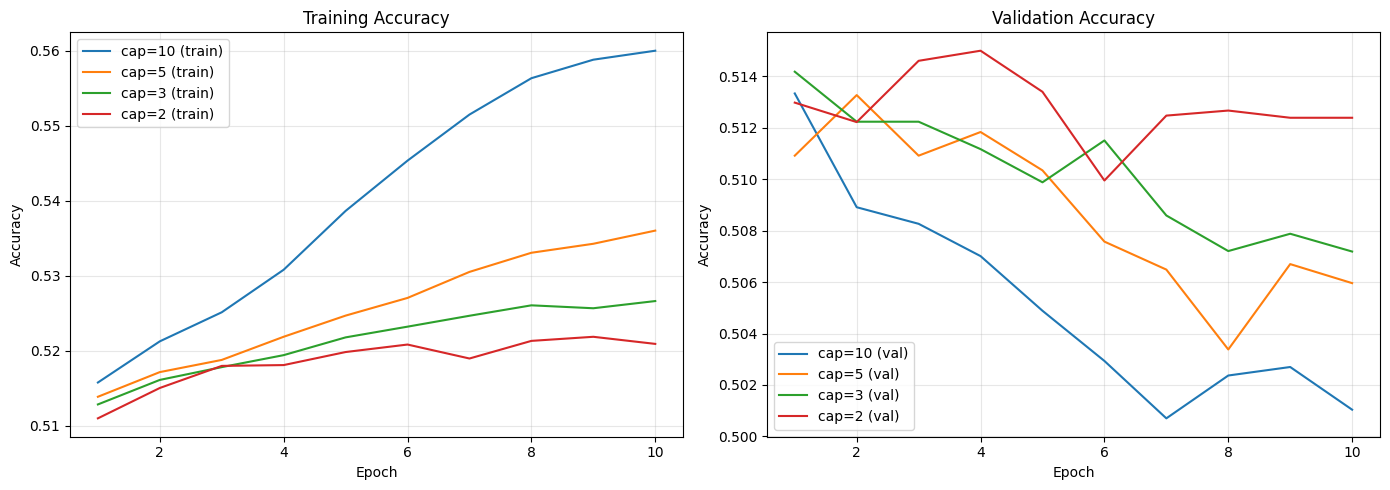

In [18]:
# Training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for cap_str, res in results.items():
    hist = pd.DataFrame(res['history'])
    axes[0].plot(hist['epoch'], hist['train_acc'], label=f"{cap_str} (train)")
    axes[1].plot(hist['epoch'], hist['val_acc'], label=f"{cap_str} (val)")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Best Model

In [19]:
# Find best config by IC Sharpe (more reliable than cumulative returns)
# Cumulative returns are unreliable because even small IC compounds unrealistically
best_config = max(results.keys(), key=lambda c: results[c]['ic_sharpe'])
print(f"Best config by IC Sharpe: {best_config}")
print(f"  IC Sharpe: {results[best_config]['ic_sharpe']:.2f}")
print(f"  Mean IC: {results[best_config]['mean_ic']:.4f}")

# Compare to baseline
if 'no_cap' in results:
    baseline_ic_sharpe = results['no_cap']['ic_sharpe']
    best_ic_sharpe = results[best_config]['ic_sharpe']
    print(f"\nBaseline (no_cap) IC Sharpe: {baseline_ic_sharpe:.2f}")
    print(f"Improvement: {best_ic_sharpe - baseline_ic_sharpe:+.2f}")
    
    if best_config != 'no_cap' and best_ic_sharpe > baseline_ic_sharpe:
        print("\n>>> Capping IMPROVES IC Sharpe!")
    else:
        print("\n>>> Baseline (no_cap) is best or tied")

best_model = results[best_config]['model']

# Note: Cumulative short returns are shown for reference but shouldn't be trusted
# because even modest IC compounds to unrealistic returns over 238 days.
# Use IC Sharpe for model comparison instead.

Best config by IC Sharpe: cap=2
  IC Sharpe: 3.86
  Mean IC: 0.0282


In [20]:
# Only save if capped model beats baseline on IC Sharpe
baseline_ic_sharpe = results.get('no_cap', {}).get('ic_sharpe', 0)
best_ic_sharpe = results[best_config]['ic_sharpe']

if best_config != 'no_cap' and best_ic_sharpe > baseline_ic_sharpe:
    torch.save({
        "model_state_dict": best_model.state_dict(),
        "config": config,
        "price_cols": price_feat_cols,
        "fund_cols": fund_feat_cols,
        "emb_cols": emb_cols,
        "pair_cap": best_config,
    }, "data/model_capped.pt")
    print(f"Saved capped model ({best_config}) to data/model_capped.pt")
else:
    print(f"NOT saving - baseline (no_cap) has better or equal IC Sharpe")
    print(f"Use model_final.pt instead")

Saved capped model (cap=2) to data/model_capped.pt
